### Step 1: Importing the required libraries

In this step, we import the necessary libraries for data manipulation, machine learning, and deep learning:
- **pandas** and **numpy** for data handling and manipulation.
- **MinMaxScaler** from `sklearn` to scale the input features.
- **Sequential** model and **LSTM** layer from **Keras** to define and train the LSTM model.
- **pickle** to save and load the trained model and scalers.
- **EarlyStopping** to prevent overfitting during training.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pickle
from tensorflow.keras.callbacks import EarlyStopping


### Step 2 and 3: Loading and Preprocessing the Data

In this step, we:
1. Firstly we loaded the datase from an Excel file (`huc2_5_correct.xlsx`).
2. Then, we converted the **'Date'** column to datetime format to ensure it's properly parsed.
3. We went on to generate lagged features for each non-discharge variable. Lagging helps the model learn temporal dependencies from previous time steps.
4. Then, we concatenated the lagged columns,**Concatenate lagged columns** to the dataset and drop any rows with missing values due to the lagging.


In [ ]:
# Step 2: Load the dataset
df = pd.read_excel(discharge/huc2_5_correct.xlsx')

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 3: Generate lagged columns for features (excluding 'Date' and 'Discharge')
n_steps = 15  # Number of lagged steps
lagged_columns = []

for col in df.columns[1:]:
    if col != 'Discharge (ft3/s)':  # Ensure you don't use discharge (which is missing)
        for lag in range(1, n_steps + 1):
            lagged_columns.append(df[col].shift(lag).rename(f"{col}_lag_{lag}"))

# Concatenate lagged columns with the original dataset
df_lagged = pd.concat([df] + lagged_columns, axis=1)

# Drop rows with NaN due to lagging
df_lagged = df_lagged.dropna()


### Step 4 and 5: Splitting the Data into Training and Validation Sets

Here, we:
1. First we splitted the data into a **training set** (1980-2022) and a **validation set** (2023) for blind validation.
2. We prepared the features (`X_train`) and target (`y_train`) for the training set by dropping the 'Date' and 'Discharge (ft3/s)' columns.
3. We normalized both the features (`X_train`) and the target (`y_train`) using `MinMaxScaler`. This is crucial for LSTM models since they are sensitive to the scale of the input data.
4. We then saved the feature names for future use.


In [3]:
# Step 4: Split into training (1980-2022) and blind validation (2023)
train_data = df_lagged[df_lagged['Date'] < pd.Timestamp('2023-01-01')]
blind_data = df_lagged[df_lagged['Date'] >= pd.Timestamp('2023-01-01')]

# Step 5: Prepare training features and target
X_train = train_data.drop(['Date', 'Discharge (ft3/s)'], axis=1)
y_train = train_data['Discharge (ft3/s)']

# Normalize features and target
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Save feature names for later use
feature_names = X_train.columns.tolist()

### Step 6 and 7: Reshaping Data for LSTM and Defining the Model

In this step:
1. We reshaped the data for LSTM. The LSTM expects the input data in a 3D shape: `(samples, time steps, features)`. Since we have no time dimension, we set the time step to 1.
2. We defeined the LSTM model as follow:
   - The first LSTM layer with 128 units and `return_sequences=True` allowed us to stack more LSTM layers.
   - A Droupout Layer was added to prevent overfitting.
   - A second LSTM layer with 64 units was added.
   - The final layer is a Dense Layer with a single output unit for regression.
   - We compiled the model using the Adam optimizer and mean squared error loss.


In [4]:
# Step 6: Reshape data for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Step 7: Define the LSTM Model
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\J01040445\AppData\Local\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Step 8: Training the Model and Saving It

In this step:
1. We used Early Stopping to avoid overfitting. The training stops if the validation loss does not improve after 10 epochs.
2. We trained the models on the training data for up to 100 epochs with a batch size of 4. A 10% validation split is used during training.
3. Finally, we saved the trained model and the scalers to files (`improved_lstm_model.h5`, `scaler.pkl`, `y_scaler.pkl`) so that we can use them later for predictions.


In [5]:
# Step 8: Use Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=4, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Save the model and scalers
model.save("improved_lstm_model.h5")
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("y_scaler.pkl", "wb") as f:
    pickle.dump(y_scaler, f)

Epoch 1/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0255 - val_loss: 0.0116
Epoch 2/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0169 - val_loss: 0.0099
Epoch 3/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0146 - val_loss: 0.0091
Epoch 4/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0126 - val_loss: 0.0074
Epoch 5/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0117 - val_loss: 0.0085
Epoch 6/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0115 - val_loss: 0.0091
Epoch 7/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0121 - val_loss: 0.0067
Epoch 8/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 9/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0107 - val_loss: 0.0066
Epoch 10/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 11/100
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104 - val_loss: 0.0067
Epoch 12/100
751/751 ━━━━━━━━━━━━━━━━━━━━

### Steps 9 and 10: Preparing the 2023 Data for Prediction and Predicting Discharge

1. We prepared the 2023 data by dropping the 'Date' and 'Discharge' columns, and aligning the features to match those used during training.
2. The data was normalized using the previously saved scaler and reshaped for LSTM input.
3. We used the trained model to predict discharge for 2023.
4. The predictions were then combined with the actual discharge data and saved to a CSV file for future analysis.


In [6]:
# Step 9: Prepare 2023 data for prediction
X_blind = blind_data.drop(['Date', 'Discharge (ft3/s)'], axis=1)

# Align blind data features to match training feature names
X_blind = X_blind.reindex(columns=feature_names, fill_value=0)

# Normalize and reshape blind data
X_blind_scaled = scaler.transform(X_blind)
X_blind_scaled = X_blind_scaled.reshape((X_blind_scaled.shape[0], 1, X_blind_scaled.shape[1]))

# Step 10: Predict discharge for 2023
y_blind_pred_scaled = model.predict(X_blind_scaled)
y_blind_pred = y_scaler.inverse_transform(y_blind_pred_scaled)

# Combine predictions with dates
results_2023 = pd.DataFrame({
    "Date": blind_data['Date'].reset_index(drop=True),
    "Actual Discharge (ft3/s)": blind_data['Discharge (ft3/s)'].reset_index(drop=True),
    "Predicted Discharge (ft3/s)": y_blind_pred.flatten()
})

results_2023.to_csv("2023_discharge_predictions.csv", index=False)
print("Predicted discharge for 2023 saved to '2023_discharge_predictions.csv'.")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted discharge for 2023 saved to '2023_discharge_predictions.csv'.


### Step 11: Evaluating the Model Performance

In this step, we evaluated the performance of our trained LSTM model by calculating several common regression metrics:
- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors. Lower values indicate better model performance.
- **MSE (Mean Squared Error)**: Similar to RMSE, but not in the same units as the original data.
- **MAE (Mean Absolute Error)**: The average of the absolute errors between actual and predicted values.
- **R² (R-squared)**: A measure of how well the model explains the variance in the actual data. Values closer to 1 indicate a better fit.

These metrics gave us a better understanding of how well our model performs on the 2023 data and whether it is making accurate predictions.


In [7]:
# Step 11: Evaluating the model on 2023 data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get the actual discharge values from the blind_data
y_actual = blind_data['Discharge (ft3/s)'].values

# Calculate the evaluation metrics
rmse = np.sqrt(mean_squared_error(y_actual, y_blind_pred))
mse = mean_squared_error(y_actual, y_blind_pred)
mae = mean_absolute_error(y_actual, y_blind_pred)
r2 = r2_score(y_actual, y_blind_pred)

# Print the evaluation metrics
print(f"Evaluation Metrics for 2023 Predictions:")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

Evaluation Metrics for 2023 Predictions:
RMSE: 73570.96465026833
MSE: 5412686839.571032
MAE: 54643.936279965754
R²: 0.8889899841135807


### Ste[ 12: Visualizing the Actual vs Predicted Discharge for 2023

In this step, we compared the actual discharge values with the predicted discharge values for the year 2023. This allowed us to visually assess how well our LSTM model has performed by comparing the predicted results against the actual observed values.

We plotted the following two curves below:
- **Predicted Discharge (ft³/s):** The values predicted by our LSTM model.
- **Actual Discharge (ft³/s):** The observed values for discharge, representing the true data.


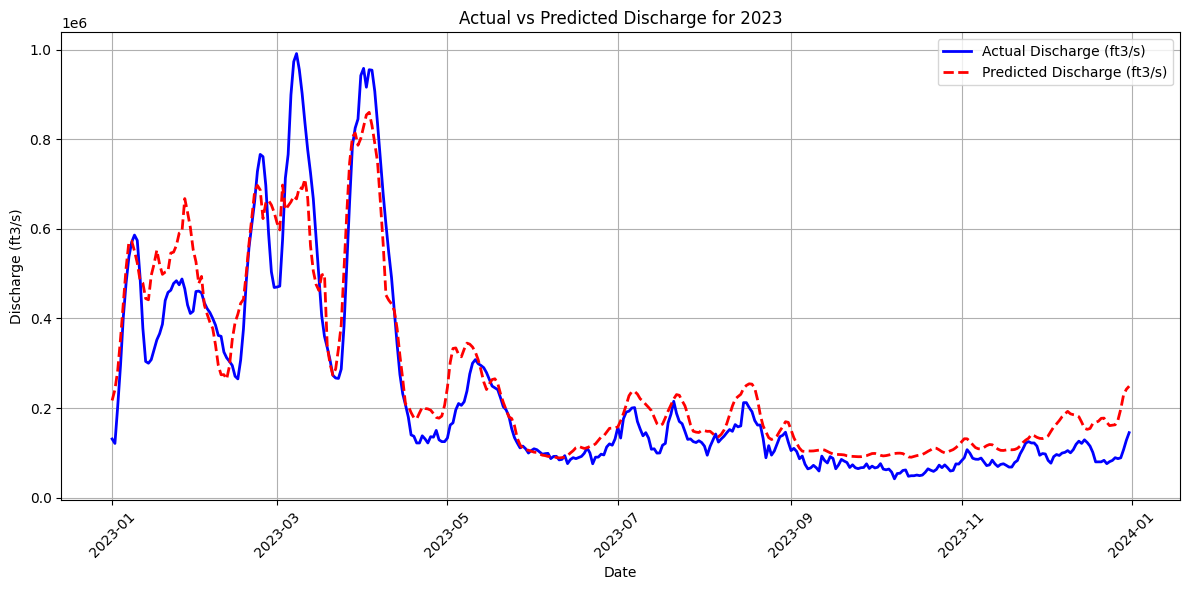

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results CSV file containing both actual and predicted discharge data
results_2023 = pd.read_csv('2023_discharge_predictions.csv')

# Ensure the 'Date' column is in datetime format
results_2023['Date'] = pd.to_datetime(results_2023['Date'], errors='coerce')

# Plot the actual vs predicted discharge
plt.figure(figsize=(12, 6))

# Plot actual discharge
plt.plot(results_2023['Date'], results_2023['Actual Discharge (ft3/s)'], label='Actual Discharge (ft3/s)', color='b', linestyle='-', linewidth=2)

# Plot predicted discharge
plt.plot(results_2023['Date'], results_2023['Predicted Discharge (ft3/s)'], label='Predicted Discharge (ft3/s)', color='r', linestyle='--', linewidth=2)

# Customize the plot
plt.title('Actual vs Predicted Discharge for 2023')
plt.xlabel('Date')
plt.ylabel('Discharge (ft3/s)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Add legend
plt.legend()

# Show the plot
plt.show()